In [1]:
from spectral import *
import spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import scipy
import spectral as spy
from scipy.integrate import cumtrapz
from numpy import linalg as LA

img = spectral.open_image('D1_F12_H1_Cropped.hdr')
header ="C:/Users/Yaniv/PycharmProjects/project_stanley/D1_F12_H1_Cropped.hdr"
data = open_image(header)
my_cube = data.load().copy()

In [2]:
def visual(data, name,bands):  # Visualize the cube
    # Choose four different bands to display
    data = (255 / np.max(data.flatten())) * data
    bands = [bands[0], bands[1], bands[2], bands[3],bands[4],bands[5]]
    # Create a figure with subplots to display the band images
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
    # Display each band image in a subplot
    for band, ax in zip(bands, axes.flat):
        band_image = data[:, :, band]
        ax.imshow(band_image, cmap='gray')
        ax.set_title('Band {}'.format(band))
    plt.suptitle("{}".format(name))
    plt.show()
# bands = [1, 2, 3, 120]
# visual(my_cube, "Data",bands)

Whiting:

In [352]:
M = np.zeros(np.shape(my_cube))
for i in range(M.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(my_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(my_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M[:, :, i] = neighbor_sum / (neighbor_count - 1)
X_MINUS_M = np.subtract(my_cube, M)
arg_cov_n = X_MINUS_M.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_n = np.cov(arg_cov_n.transpose())  #Transpose- Python vs. Matlab
eigenvalues_n, eigenvectors_n = np.linalg.eig(phi_n)

In [7]:
white_cube = np.zeros(np.shape(my_cube))
my_matrix = np.diag(np.power(eigenvalues_n,-0.5))@eigenvectors_n.T
for i in range(np.shape(my_cube)[0]):
    for j in range(np.shape(my_cube)[1]):
        white_cube[i,j,:] = my_matrix@my_cube[i,j,:]

M_white = np.zeros(np.shape(white_cube)) #S'
for i in range(M.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(white_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(white_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M_white[:, :, i] = neighbor_sum / (neighbor_count - 1)

Projection:

In [155]:
arg_cov_s = M_white.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_s = np.cov(arg_cov_s.transpose())  #Transpose- Python vs. Matlab
eigenvalues_s, eigenvectors_s = np.linalg.eig(phi_s)
sorted_indices_s = np.argsort(eigenvalues_s)[::-1]
sorted_eigenvalues_s = eigenvalues_s[sorted_indices_s]
sorted_eigenvectors_s = eigenvectors_s[:, sorted_indices_s] #(511, 511)

In [157]:
final_cube = np.zeros(np.shape(my_cube))
for i in range(np.shape(my_cube)[0]):
    for j in range(np.shape(my_cube)[1]):
        final_cube[i,j,:] = sorted_eigenvectors_s.T.real@white_cube[i,j,:] #white

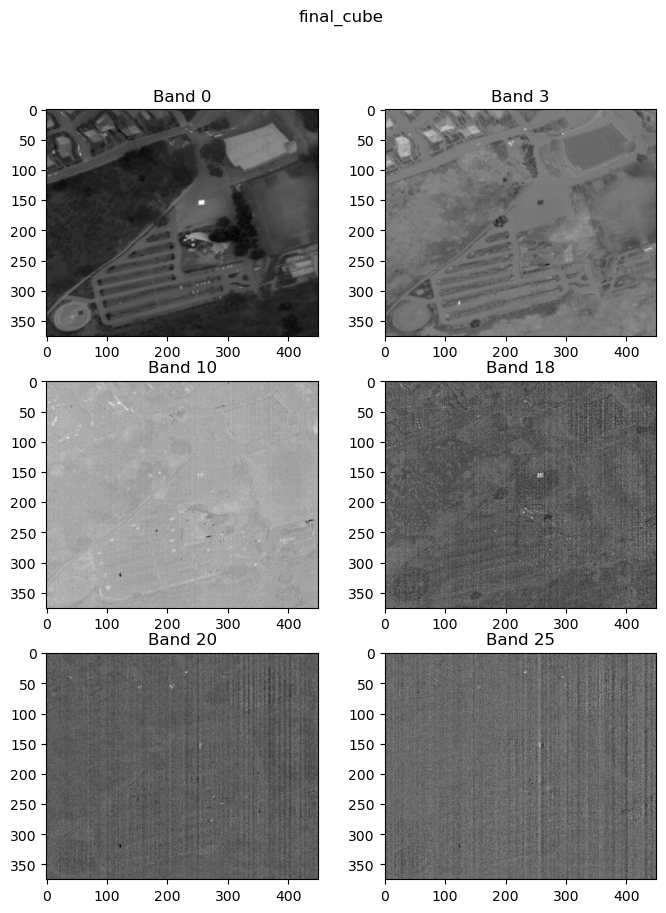

In [364]:
bands = [0,3,10,18,20,25]
visual(final_cube, "final_cube",bands)

The 5 biggest eigenvalues of S are: [121.38893531  42.19729722  37.18158206  21.39216726   8.93372676]
The 5 smallest eigenvalues of S are: [0.09075213 0.09043934 0.0903537  0.08965214 0.08948716]
The sums ratio: 0.7937631702298927


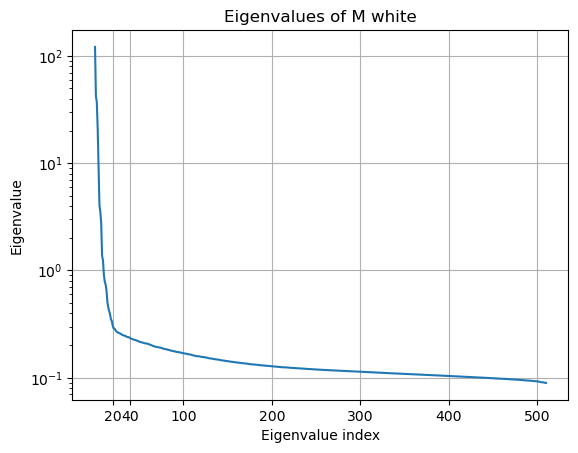

In [365]:
print("The 5 biggest eigenvalues of S are:", sorted_eigenvalues_s[0:5])
print("The 5 smallest eigenvalues of S are:", sorted_eigenvalues_s[-5:])
print("The sums ratio:", np.sum(sorted_eigenvalues_s[0:21])/np.sum(sorted_eigenvalues_s))
plt.plot(sorted_eigenvalues_s)
plt.title("Eigenvalues of S")
plt.xlabel("Eigenvalue index")
x_ticks = [20,40]+list(np.linspace(100, 500, 5))
plt.xticks(x_ticks)
plt.ylabel("Eigenvalue")
plt.grid()
plt.yscale('log')
plt.title("Eigenvalues of M white")
plt.show()

The first channel where the std is smaller than 1.1 is: 18


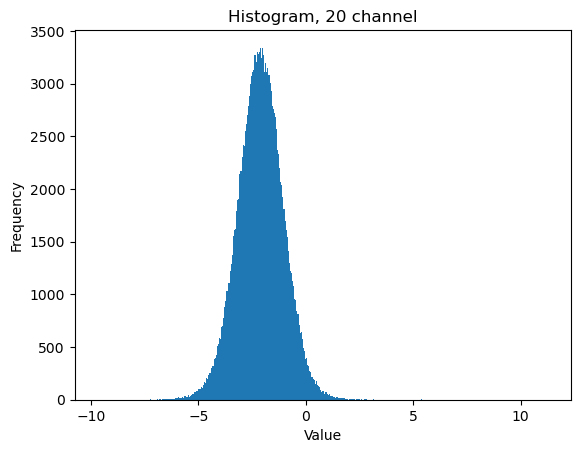

the ratio between the histogram of this channel to the histogram of the last channel is: 1.3482590396253493


In [371]:
def plot_histogram(matrix,k):
    flattened_matrix = matrix.flatten()  # Flatten the matrix into a 1-D array
    plt.hist(flattened_matrix, bins='auto')  # Plot the histogram
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram, {} channel'.format(k))
    plt.show()

list_of_std = [np.std(final_cube[:,:,i].flatten()) for i in range(np.shape(final_cube)[2])]
print("The first channel where the std is smaller than 1.1 is:", np.nonzero(np.array(list_of_std) < 1.1)[0][0])
k = np.nonzero(np.array(list_of_std) < 1.1)[0][0]
plot_histogram(final_cube[:,:,20],20)

#plot_histogram(final_cube[:,:,np.nonzero(np.array(list_of_std) < 1.1)[0][0]])
hist0, bin0 =  np.histogram(final_cube[:,:,k])
hist_f, bin_f = np.histogram(final_cube[:,:,-1])
print("the ratio between the histogram of this channel to the histogram of the last channel is:", np.trapz(hist0, bin0[:-1])/np.trapz(hist_f, bin_f[:-1]))


In [366]:
print(np.std(final_cube[:,:,0].flatten()))
print(np.std(final_cube[:,:,-1].flatten()))

11.226339940601424
0.9230306665638941


Part 2:

In [345]:
number_of_bands = 21
MF = True
RX = False
bins_num = 100
p = 0.01
t = my_cube[2, 4, :]
new_cube = final_cube[:, :, :number_of_bands]
t_new = new_cube[2, 4, :]
t_inv_phi = np.dot(t, LA.inv(phi_n))
t_inv_phi_t = np.dot(t_inv_phi, t)
########################################################################## white
t_white = white_cube[2, 4, :]
arg_cov_n_white = np.subtract(white_cube,M_white).reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_n_white = np.cov(arg_cov_n_white.transpose())  #Transpose- Python vs. Matlab
t_inv_phi_white = np.dot(t_white, LA.inv(phi_n_white))

eigenvalues_n_white, eigenvectors_n_white = np.linalg.eig(phi_n_white)
t_inv_phi_new_eigen = np.dot(t_new, LA.inv(np.diag(eigenvalues_n_white[:number_of_bands])))
##########################################################################
M_new = np.zeros(np.shape(new_cube))
for i in range(M_new.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(new_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(new_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M_new[:, :, i] = neighbor_sum / (neighbor_count - 1)
X_MINUS_M_new = np.subtract(new_cube, M_new)
arg_cov_new = X_MINUS_M_new.reshape(np.shape(M_new)[0] * np.shape(M_new)[1], np.shape(M_new)[2])
phi_new = np.cov(arg_cov_new.transpose())  # Transpose- Python vs. Matlab
eigenvalues_new, eigenvectors_new = np.linalg.eig(phi_new)
t_inv_phi_new = np.dot(t_new, LA.inv(phi_new))
t_inv_phi_t_new = np.dot(t_inv_phi_new, t_new)

In [340]:
# #TODO - why its correct
#print((eigenvectors_n_white@eigenvectors_n_white.T).real) #that the problem
# arg_cov_s = M_white.reshape(img.shape[0] * img.shape[1], img.shape[2])
# phi_s = np.cov(arg_cov_s.transpose())  #Transpose- Python vs. Matlab
# eigenvalues_s, eigenvectors_s = np.linalg.eig(phi_s)
# sorted_indices_s = np.argsort(eigenvalues_s)[::-1]
# sorted_eigenvalues_s = eigenvalues_s[sorted_indices_s]
# sorted_eigenvectors_s = eigenvectors_s[:, sorted_indices_s] #(511, 511)
# X_MINUS_M_white = np.subtract(white_cube, M_white)
#
# eigenvalues_n_white, eigenvectors_n_white = np.linalg.eig(phi_n_white)
# i,j = 14,62
# print(sorted_eigenvectors_s.real@sorted_eigenvectors_s.T.real)
# print(phi_n_white)
# print(t_white.T@phi_n_white@X_MINUS_M_white[i,j,:])
# print(((sorted_eigenvectors_s.T.real@t_white).T@sorted_eigenvectors_s.T.real@X_MINUS_M_white[i,j,:]).real)
# print(((eigenvectors_n_white.T.real@t_white).T@np.diag(eigenvalues_n_white)@eigenvectors_n_white.T.real@X_MINUS_M_white[i,j,:]).real)

In [341]:
MF_NT = np.zeros((img.shape[0], img.shape[1]))
MF_WT = np.zeros((img.shape[0], img.shape[1]))
if MF:
    ALG = 'MF'
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            MF_NT[i, j] = np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :]))#np.dot(t_inv_phi_white, (white_cube[i, j, :] - M_white[i, j, :]))
            MF_WT[i, j] = np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :] + p * t))#np.dot(t_inv_phi_white, (white_cube[i, j, :] - M_white[i, j, :] + p * t_white))
elif RX:
    ALG = 'RX'
    p = 0.2 #TODO just note that it big for RX filter: 0.2
    bins_num = 500
    A = LA.inv(phi_n)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            MF_NT[i, j] = X_MINUS_M[i, j, :]@A@ X_MINUS_M[i, j, :]
            MF_WT[i, j] = (X_MINUS_M[i, j, :]+p*t)@A@(X_MINUS_M[i, j, :]+p*t)
else: #ACE
    ALG = 'ACE'
    A = LA.inv(phi_n)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            MF_NT[i, j] = pow(np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :])),2)/(t_inv_phi_t*np.dot(np.dot((my_cube[i, j, :] - M[i, j, :]), A), (my_cube[i, j, :] - M[i, j, :])))
            MF_WT[i, j] = pow(np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :] + p * t)),2)/(t_inv_phi_t*np.dot(np.dot((my_cube[i, j, :] - M[i, j, :] + p * t), A), (my_cube[i, j, :] - M[i, j, :] + p * t)))
NT_val, NT_bins = np.histogram(MF_NT, bins=bins_num)
WT_val, WT_bins = np.histogram(MF_WT, bins=bins_num)

In [346]:
def neighbours(cube,i,j):
    if i == 0:
        if j==0:
            return cube[i,j+1,:],cube[i+1,j,:],cube[i+1,j+1,:]
        elif j==cube.shape[1]-1:
            return cube[i,j-1,:],cube[i+1,j-1,:],cube[i+1,j,:]
        else:
            return cube[i,j-1,:],cube[i,j+1,:],cube[i+1,j-1,:],cube[i+1,j,:],cube[i+1,j+1,:]
    elif i==cube.shape[0]-1:
        if j==0:
            return cube[i-1,j,:],cube[i-1,j+1,:],cube[i,j+1,:]
        elif j==cube.shape[1]-1:
            return cube[i-1,j-1,:],cube[i-1,j,:],cube[i,j-1,:]
        else:
            return cube[i-1,j-1,:],cube[i-1,j,:],cube[i-1,j+1,:],cube[i,j-1,:],cube[i,j+1,:]

    elif j==0 and i!=0 and i!=cube.shape[0]-1:
        return cube[i-1,j,:],cube[i-1,j+1,:],cube[i,j+1,:],cube[i+1,j,:],cube[i+1,j+1,:]
    elif j==cube.shape[1]-1 and i!=0 and i!=cube.shape[0]-1:
        return cube[i-1,j-1,:],cube[i-1,j,:],cube[i,j-1,:],cube[i+1,j-1,:],cube[i+1,j,:]
    else:
        return cube[i-1,j-1,:],cube[i-1,j,:],cube[i-1,j+1,:],cube[i,j-1,:],cube[i,j+1,:],cube[i+1,j-1,:],cube[i+1,j,:],cube[i+1,j+1,:]

SD = np.zeros(np.shape(new_cube[:,:,:number_of_bands]))
for i in range(new_cube.shape[0]):
    for j in range(new_cube.shape[1]):
        for b in range(number_of_bands):
            SD[i,j,b] = np.std(np.array(neighbours(new_cube,i,j))[:,b])**2

In [347]:
MF_NT_new = np.zeros((img.shape[0], img.shape[1]))
MF_WT_new = np.zeros((img.shape[0], img.shape[1]))
if MF:
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            MF_NT_new[i, j] = MF_WT_new[i, j] = np.dot(np.dot(t_new, LA.inv(np.diag(np.maximum(SD[i,j,:number_of_bands],eigenvalues_new[:number_of_bands].real)))
), (new_cube[i, j, :] - M_new[i, j, :]))#np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :]))
            MF_WT_new[i, j] = np.dot(np.dot(t_new, LA.inv(np.diag(np.maximum(SD[i,j,:number_of_bands],eigenvalues_new[:number_of_bands].real)))
), (new_cube[i, j, :] - M_new[i, j, :] + p * t_new))#np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :] + p * t_new))
elif RX:
    A_new = LA.inv(phi_new)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            MF_NT_new[i, j] = X_MINUS_M_new[i, j, :]@A_new@ X_MINUS_M_new[i, j, :]
            MF_WT_new[i, j] = (X_MINUS_M_new[i, j, :]+p*t_new)@A_new@(X_MINUS_M_new[i, j, :]+p*t_new) #TOOD because p is big, that problem
else: #ACE
    A_new = LA.inv(phi_new)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            MF_NT_new[i, j] = pow(np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :])),2)/(t_inv_phi_t_new*np.dot(np.dot((new_cube[i, j, :] - M_new[i, j, :]), A_new), (new_cube[i, j, :] - M_new[i, j, :])))
            MF_WT_new[i, j] = pow(np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :] + p * t_new)),2)/(t_inv_phi_t_new*np.dot(np.dot((new_cube[i, j, :] - M_new[i, j, :] + p * t_new), A_new), (new_cube[i, j, :] - M_new[i, j, :] + p * t_new)))
NT_val_new, NT_bins_new = np.histogram(MF_NT_new, bins=bins_num)
WT_val_new, WT_bins_new = np.histogram(MF_WT_new, bins=bins_num)

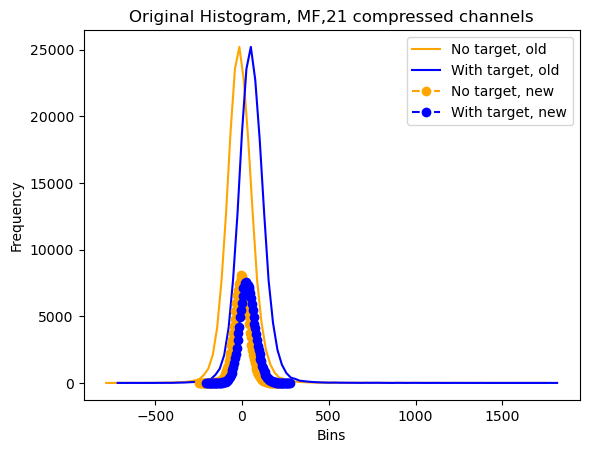

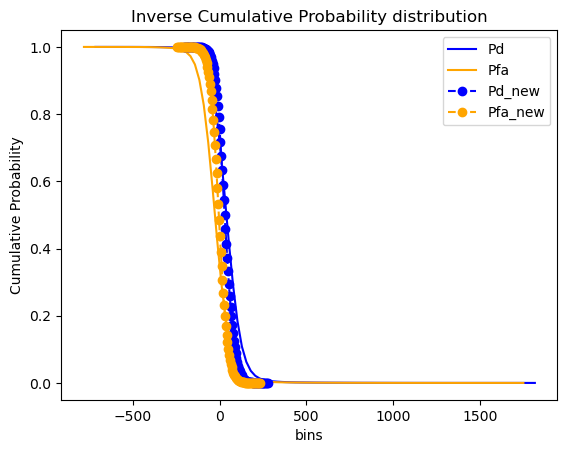

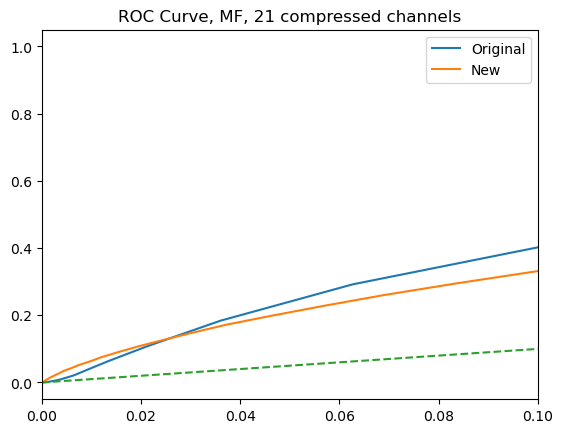

MF,21 compressed channels
Old performance, using 'Area Test':
th= 0.001: 0.00015855060589282686
th= 0.01: 0.015341601284888082
th= 0.1: 0.11765503889105476
New performance, using 'Area Test':
th= 0.001: 0.0030208080720743103
th= 0.01: 0.03600808983187521
th= 0.1: 0.12772861283084244


In [348]:
Pd = 1 - (np.cumsum(WT_val) / np.sum(WT_val))
Pfa = 1 - (np.cumsum(NT_val) / np.sum(NT_val))
Pd_new = 1 - (np.cumsum(WT_val_new) / np.sum(WT_val_new))
Pfa_new = 1 - (np.cumsum(NT_val_new) / np.sum(NT_val_new))

plt.plot(NT_bins[:-1], NT_val,color='orange', label='No target, old')
plt.plot(WT_bins[:-1], WT_val,color='blue', label='With target, old')
plt.plot(NT_bins_new[:-1], NT_val_new,color='orange', label='No target, new',marker="o",linestyle='--')
plt.plot(WT_bins_new[:-1], WT_val_new,color='blue' ,label='With target, new',marker="o",linestyle='--')
plt.xlabel("Bins")
if RX:
    plt.title("Original Histogram, {},P={},{} compressed channels".format(ALG,p,number_of_bands))
    plt.xlim(-100, 1600)
plt.title("Original Histogram, {},{} compressed channels".format(ALG,number_of_bands))
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.plot(WT_bins[:-1], Pd,color='blue', label="Pd")
plt.plot(NT_bins[:-1], Pfa,color='orange', label="Pfa")
plt.plot(WT_bins_new[:-1],Pd_new,color='blue',  marker="o",label="Pd_new",linestyle='--')
plt.plot(NT_bins_new[:-1],Pfa_new,color='orange',  marker="o",label="Pfa_new",linestyle='--')
plt.xlabel('bins')
plt.ylabel('Cumulative Probability')
plt.title('Inverse Cumulative Probability distribution')
plt.legend()
plt.show()

th = 0.1
index = max(bins_num - np.argmax(WT_bins > NT_bins[-1]), np.argmax(NT_bins > WT_bins[0]))
Pd = np.pad(Pd, (index, 0), mode='constant', constant_values=(1, 1))
Pfa = np.pad(Pfa, (0, index), mode='constant', constant_values=(0, 0))
Pd = np.flip(Pd)
Pfa = np.flip(Pfa)

index_new = max(bins_num - np.argmax(WT_bins_new > NT_bins_new[-1]), np.argmax(NT_bins_new > WT_bins_new[0]))
Pd_new = np.pad(Pd_new, (index_new, 0), mode='constant', constant_values=(1, 1))
Pfa_new = np.pad(Pfa_new, (0, index_new), mode='constant', constant_values=(0, 0))
Pd_new = np.flip(Pd_new)
Pfa_new = np.flip(Pfa_new)

plt.title('ROC Curve, {}, {} compressed channels'.format(ALG,number_of_bands))
plt.plot(Pfa, Pd, label='Original')
plt.plot(Pfa_new, Pd_new,label='New')
plt.plot([0, th], [0, th], '--')
plt.xlim(0, th)
plt.legend(['Original', 'New'])
plt.show()

from scipy.integrate import trapz
def area(th):
    cond = np.where(Pfa > th)[0][0]
    Pd_mask = Pd.copy()
    Pd_mask[cond:] = 0
    A = trapz(Pd_mask, Pfa)
    return (A - 0.5 * pow(th, 2)) / (th - 0.5 * pow(th, 2))
print("{},{} compressed channels".format(ALG,number_of_bands))
print("Old performance, using 'Area Test':")
print("th= 0.001:", area(0.001))
print("th= 0.01:", area(0.01))
print("th= 0.1:", area(0.1))

def area_new(th):
    cond_new = np.where(Pfa_new > th)[0][0]
    Pd_mask_new = Pd_new.copy()
    Pd_mask_new[cond_new:] = 0
    A_new = trapz(Pd_mask_new, Pfa_new) #TODO
    return (A_new - 0.5 * pow(th, 2)) / (th - 0.5 * pow(th, 2))
print("New performance, using 'Area Test':")
print("th= 0.001:", area_new(0.001))
print("th= 0.01:", area_new(0.01))
print("th= 0.1:", area_new(0.1))

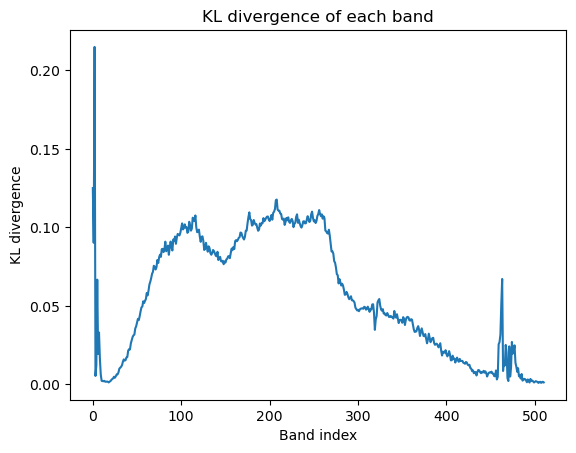

In [351]:
from scipy.stats import norm
def kl_divergence(vector):
    # Calculate the histogram of the vector
    counts, _ = np.histogram(vector, bins=100, density=True)

    # Generate the corresponding bin centers
    bin_centers = 0.5 * (_[1:] + _[:-1])

    # Calculate the PDF of the Gaussian distribution
    gaussian_pdf = norm.pdf(bin_centers, np.mean(vector), np.std(vector))

    # Avoid division by zero
    epsilon = 1e-8

    # Calculate the KL divergence
    kl_div = np.sum(counts * np.log((counts + epsilon) / (gaussian_pdf + epsilon)))

    return kl_div

plt.plot([kl_divergence(X_MINUS_M[:, :, i].flatten()) for i in range(X_MINUS_M.shape[-1])])
plt.title("KL divergence of each band")
plt.xlabel("Band index")
plt.ylabel("KL divergence")
plt.show()